In [ ]:
# default_exp nbeats.metrics

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd
%load_ext autoreload
%autoreload 2

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# N-Beats metrics

> A basic architecture for time series forecasting.


The approach is based on https://arxiv.org/abs/1905.10437


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.torch_core import *
from torch.autograd import Variable
from fastseq.all import *

from fastseq.nbeats.model import *

## Metrics 

In [ ]:
# export
def _get_key_from_nested_dct(dct, s_key, exclude = [], namespace=''):
    r = {}
    for key in dct.keys():
        if sum([exc in key for exc in exclude])== 0 :
            if type(dct[key]) == dict:
                r.update(_get_key_from_nested_dct(dct[key], s_key, exclude, namespace=namespace+key))
            if s_key in key:
                r[namespace+key] = dct[key]
    return r

In [ ]:
dct = {'foo':{'bar':1},'bar':2,'foo2':{'foo3':3},'ignore':{'bar':1000}}
r = _get_key_from_nested_dct(dct,'bar',['ignore'])
test_eq(r,{'foobar': 1, 'bar': 2})

In [ ]:
#export
class NBeatsTheta(Metric):
    "The sqaure of the `theta` for every block. "
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)   
        theta_dct = _get_key_from_nested_dct(learn.model.dct,'theta',['bias','total','att'])
        t = torch.sum(tensor([v.float().abs().mean() for k,v in theta_dct.items()]))
        self.total += to_detach(t.abs().mean())*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return "theta"

In [ ]:
horizon, lookback = 7,10
items = L(np.arange(-5,100)[None,:],np.arange(500,550)[None,:],np.arange(-110,-56)[None,:]).map(tensor)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=1, after_batch = NormalizeTS()
                               )

mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics=[NBeatsTheta()],
               )

learn.fit(3,.1)
test_eq(type(learn.metrics[0].value),Tensor)

Train:89; Valid: 33; Test 3


epoch,train_loss,valid_loss,theta,time
0,6.493773,1.365213,3.344305,00:00
1,5.581142,10.075838,4.545395,00:00
2,5.282518,14.126739,4.378864,00:00


In [ ]:
#export
class NBeatsBackwards(Metric):
    "The loss according to the `loss_func` on the backwards part of the time-serie."
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)  
        loss = to_detach(learn.loss_func(learn.pred[:,0,:learn.model.lookback], learn.yb[0][:,0,:learn.model.lookback]))
#         print('NBeatsBackwards',loss)
        self.total += loss.mean()*bs        
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return "b_loss"

In [ ]:
# hide
items = dummy_data_generator(50, 10, nrows=3)
data = TSDataLoaders.from_items(items, horizon = horizon,lookback = lookback, bs=32)
mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics=[NBeatsBackwards()],
#                 cbs=L(NBeatsTrainer())
               )
learn.loss_func
learn.fit(2,.1)

Train:60; Valid: 33; Test 3


epoch,train_loss,valid_loss,b_loss,time
0,5.326888,7.034452,3.942137,00:00
1,5.061519,3.065765,1.689187,00:00
2,4.521320,2.065722,0.737519,00:00


In [ ]:
#export
class NBeatsForward(Metric):
    "The loss according to the `loss_func` on the backwards part of the time-serie."
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)  
        loss = learn.loss_func(learn.pred[:,0,-learn.model.horizon:], learn.yb[0][:,0,-learn.model.horizon:])
        self.total += loss*bs        
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return "f_loss"

In [ ]:
np.arange(17)[-7:]

array([10, 11, 12, 13, 14, 15, 16])

In [ ]:
# hide
items = dummy_data_generator(50, 10, nrows=3)
data = TSDataLoaders.from_items(items, horizon = horizon,lookback = lookback, bs=32)
mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics=[NBeatsForward()],
               )
learn.loss_func
learn.fit(3,.1)
test_eq(type(learn.metrics[0].value), Tensor)
test_eq(learn.metrics[0].value<learn.loss, True)

Train:60; Valid: 33; Test 3


epoch,train_loss,valid_loss,f_loss,time
0,4.812490,11.063529,20.257753,00:00
1,4.920998,4.525421,9.666596,00:00
2,4.153901,3.269542,6.711803,00:00


AssertionError: ==:
False
True

In [ ]:
horizon, lookback = 7,10
items = L(np.arange(-5,100)[None,:],np.arange(500,550)[None,:],np.arange(-110,-56)[None,:]).map(tensor)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=1, after_batch = NormalizeTS()
                             )
mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics=[NBeatsBackwards(), NBeatsForward()],
               )

learn.fit(3,.1)
test_eq(learn.metrics[0].value+learn.metrics[1].value, learn.loss)

Train:89; Valid: 33; Test 3


epoch,train_loss,valid_loss,b_loss,f_loss,time
0,6.532873,16.850056,19.648609,12.852122,00:00
1,6.798359,18.494629,24.360195,10.115256,00:00
2,5.986290,20.734509,29.555113,8.133649,00:00


AssertionError: ==:
37.68876266479492
20.734508514404297

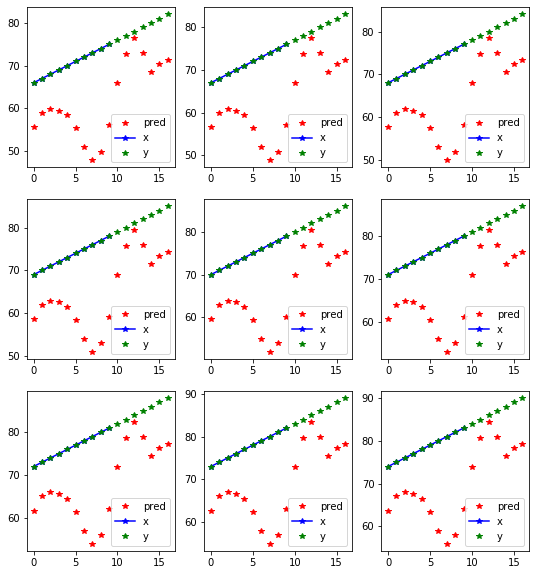

In [ ]:
learn.show_results()

## Callbacks

In [ ]:
# export
class NBeatsAttention(Callback):  
    def means(self, df=True):
        theta_means = {k.replace('theta',''):v.float().cpu().data for k,v in _get_key_from_nested_dct(self.learn.model.dct,'theta',['total']).items()}
        ret = {}
        for k,v in theta_means.items():
            ret[k] = {}
            for i in range(v.shape[-1]):
                ret[k].update({'theta_'+str(i)+'_mean': v[:,i].mean().numpy(),
                               'theta_'+str(i)+'_std': v[:,i].std().numpy(),
                              })
            
        att = {k.replace('attention','att_mean'):v.float().cpu().numpy() for k,v in _get_key_from_nested_dct(self.learn.model.dct,'att',['total']).items()}
        for k in ret.keys():
            for att_key in att.keys():
                if k in att_key:
                    ret[k].update({'att_mean':att[att_key].mean(),
                                   'att_std':att[att_key].std(),
                                  })
                
        if df:
            return pd.DataFrame(ret)
        return ret

In [ ]:
horizon, lookback = 7,10
items = L(np.arange(-5,100)[None,:],np.arange(500,550)[None,:],np.arange(-110,-56)[None,:]).map(tensor)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=1, after_batch = NormalizeTS()
                             )
mdl = NBeatsNet(device = data.train.device,horizon=horizon, lookback=lookback)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, 
                cbs=L( NBeatsAttention()
                     )
               )

learn.fit(3,.1)
df = learn.n_beats_attention.means()
df

Train:89; Valid: 33; Test 3


epoch,train_loss,valid_loss,time
0,4.213298,5.164949,00:00
1,5.709513,0.945609,00:00
2,5.125725,5.145122,00:00


,trend0_0,trend0_1,seasonality1_0,seasonality1_1,seasonality1_2,seasonality1_3
theta_0_mean,-2.0,2.0,0.0,0.0,2.0,0.0
theta_0_std,0.0,0.0,0.0,0.0,0.0,0.0
theta_1_mean,0.19999994,0.19999994,0.0,-1.0,0.0,-1.0
theta_1_std,0.0,0.0,0.0,0.0,0.0,0.0
theta_2_mean,-0.02,0.02,2.0,2.0,0.5,0.0
theta_2_std,0.0,0.0,0.0,0.0,0.0,0.0
theta_3_mean,NaN,0.002,NaN,-1.0,-2.0,0.0
theta_3_std,NaN,0.0,NaN,0.0,0.0,0.0
att_mean,NaN,NaN,0.333333,0.75,0.6,0.333333
att_std,NaN,NaN,0.471405,0.433013,0.489898,0.471404


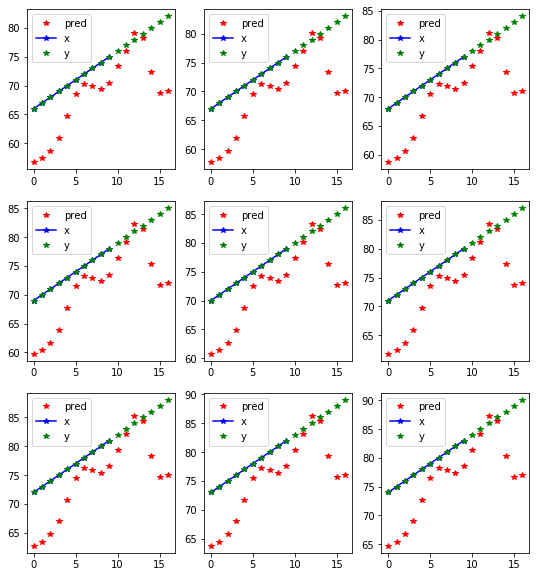

In [ ]:
learn.show_results()

In [ ]:
# hide
# old stuff
###################################################
###################################################

In [ ]:
# hide
class NBeatsBLoss(Callback): 
    def __init__(self,alpha = 1):store_attr(self,'alpha')
    def after_loss(self):
#         print('pre',self.learn.loss,self.n_beats_trainer.out['total_b_loss'].mean())
        self.learn.loss = self.learn.loss + self.n_beats_trainer.out['total_b_loss'].mean()*self.alpha
#         print('after',self.learn.loss)

In [ ]:
# hide
horizon, lookback = 7,30
items = L(np.arange(-5,100)[None,:],np.arange(250,550)[None,:],np.arange(-110,-56)[None,:]).map(tensor)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=1, after_batch = NormalizeTS()
                               )
stack_types = ('trend','seaonality')
thetas_dim= (2,4)
mdl = NBeatsNet(device = data.train.device, stack_types=stack_types, nb_blocks_per_stack = 1, horizon=horizon, lookback=lookback, thetas_dim=thetas_dim)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics = [smape,NBeatsBackwards()],
                cbs=L(NBeatsTrainer(), NBeatsAttention(), NBeatsBLoss(.7)
                     )
               )

Need to pad 1/3 time series due to length.
Train:286; Valid: 33; Test 3


KeyError: 'seaonality'

In [ ]:
# hide
test_eq(list(df.columns),[o+str(i)+'_0' for i,o in enumerate(stack_types)])
test_eq('att_mean' in list(df.axes[0]), True)
test_eq('att_std' in list(df.axes[0]), True)

In [ ]:
# hide
# TODO
def CombinedLoss(*losses, ratio:dict=None):
    _ratio = defaultdict(lambda:1.)
    if ratio is not None:
        _ratio.update(ratio)    
    ratio = _ratio
    
    def _inner(pred, truth, *args,**kwargs):
        loss = None
        for _loss in losses:
            if loss is None:
                loss = ratio[_loss.__name__] * _loss(pred, truth, *args,**kwargs)
            else:
                loss += ratio[_loss.__name__] * _loss(pred, truth, *args,**kwargs)
        return loss
    
    return _inner
  

In [ ]:
# hide
y, y_hat = torch.arange(10).float(), torch.arange(10).float()+torch.randn(10)
loss_fnc = CombinedLoss(F.mse_loss,smape)
test_eq(F.mse_loss(y,y_hat)+smape(y,y_hat),loss_fnc(y, y_hat))

r = 10
loss_fnc = CombinedLoss(F.mse_loss, smape, ratio = {'mse_loss':r})
test_eq(r*F.mse_loss(y,y_hat)+smape(y,y_hat),loss_fnc(y, y_hat))


In [ ]:
# hide
# TODO maybe add extra backwards loss also in a callback??
class NBeatsTrainer(Callback):
    "`Callback` that adds weights regularization the thetas in N-Beats training."
    def __init__(self, theta=0., b_loss=0.): 
        self.theta, self.b_loss = theta, b_loss
        self.metrics = {'theta':tensor([0.]), 'b_loss':tensor([0.])}
        self.b = None

    def begin_train(self): 
        self.out = defaultdict(dict)
        self.metrics = {'theta':tensor([0.]), 'b_loss':tensor([0.])}
        
    def begin_validate(self): 
        self.out = defaultdict(dict)
        self.metrics = {'theta':tensor([0.]), 'b_loss':tensor([0.])}
        
    def after_pred(self):
        self.b = self.pred[1] 
        self.pred[2]['total_b'] = self.pred[1] 
        self.out = concat_dct(self.pred[2], self.out)   
        self.learn.pred = self.pred[0]

    def after_loss(self):        
        # theta
        value=tensor([0.])
        for key in self.out.keys():
            if 'bias' not in key and 'total' not in key and 'att' not in key:
                v = self.out[key]['theta'].float().pow(2).mean()
                if self.theta != 0.:     
                    self.learn.loss += self.theta * v.item()
                value = value + v
        self.metrics['theta'] += value.clone().cpu().detach()
        
        # backwards 
        value = self.learn.loss_func(self.b.float(), *self.xb, reduction='mean') 
        if self.b_loss != 0.:
            self.learn.loss += self.b_loss * value.mean() 
        self.metrics['b_loss'] += value.sum().clone().detach()
            


In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.metrics.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted index.ipynb.
